## From MCMC Lab:

MCMC = Markov Chain Monte Carlo

- "Monte Carlo methods/experiments are computational algorithms that use repeated random sampling to numerically calculate a deterministic process. Often times these are used to calculate integrals or parameter marginalization."
    - draws n independent samples from a probability distribution of some variable/parameter
    - predicts outcome for each sample
    

- "A Markov chain is a random process that the future state only depends on the current and is not relient on the past. Think about a random walk where you have two options (left or right). Let's say there is a equal probability of each direction and since the next state does not depend on where the walker was 2 steps, or 3 steps or even 10,000 steps ago, this is a Markov chain."

An MCMC is a Monte Carlo experiment that makes use of a Markov chain and is generally more efficient than a plain Monte Carlo. The idea is to create a Markov chain that will have the desired probability distribution after some number of steps. Here we will use it to fit a model to some data.



### Maximum likelihood estimation (MLE) is used often in machine learning.

- likelihood function = distribution of observed data as a function of the parameters we're trying to estimate
    - what is the probability of observing our data for a range of parameter values?

- maximizing the likelihood function: maximum likelihood estimation is the parameter value that maximixes the probability of getting the data that we did.
    - equivalent to minimizing the negative log likelihood function, which will make the math easier



We'll follow the example from here https://emcee.readthedocs.io/en/stable/tutorials/line/

In [56]:
import numpy as np
from scipy.optimize import minimize


# New modules!
import emcee
import corner

import matplotlib
from matplotlib import pyplot as plt
from IPython.display import display, Math # print results for MCMC

We'll start by generating some data, using the same method from Lab 08 (Fitting Data).  This time, we'll shift our data by an extra constant, fractional amount to simulate "underestimated" uncertainties.  

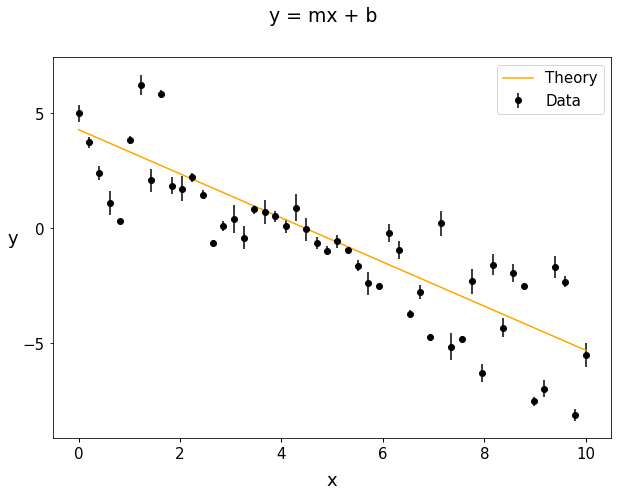

In [93]:
#Create Some data - a straight line
np.random.seed(100)     # Seed the random number generator, so the result is always the same
num = 50                # Number of data points
x=np.linspace(0,10,num) # Create an evenly spaced set of data points

# Define our parameters
m_true = -0.9594  # slope of line
b_true = 4.294    # y-intercept of line
f_true = 0.534    # the extra constant, fractional amount to "underestimate" our uncertainties

# Define the line
y_theory = m_true*x + b_true

# Add the uncertainties
yerr = np.random.rand(num)*0.5 + 0.1                    # yerr = a series of sigmas (uncertainties) between 1 and 2
y = y_theory + yerr * np.random.randn(num)        # Move y values by the sigmas ("measured" uncertainties)
y = y + np.abs(f_true * y) * np.random.randn(num) # Move y values by our extra factor "f" so uncert.s are underestimated



# Plot the data
ls = 18 #label fontsize
ts = 15 #tick label fontsize
f = plt.figure(figsize=(10,7))                      # define figure
f.suptitle("y = mx + b",fontsize=ls*1.05)           # set figure title
ax = f.add_subplot(111)                             # add a subplot (just one) to the figure
ax.errorbar(x, y, yerr=yerr,fmt='o',label="Data",c="k")   # plot data & errors
ax.plot(x,y_theory,label="Theory",c="orange")             # plot theoretical line
ax.set_xlabel("x",fontsize=ls,labelpad=10)          # set axes labels
ax.set_ylabel("y",fontsize=ls,rotation=0,labelpad=10)
ax.set_xticks(np.arange(0,11,2))                    # set axes ticks
ax.set_yticks([-5,0,5])
ax.tick_params(axis="both",which="major",labelsize=ts,direction="out",pad=5,right=False,top=False) # adjust ticks
ax.tick_params(axis="x",rotation=0,color="k",labelcolor="k",width=1,length=4)
ax.legend()                                         # add the legend
plt.show()                                          # display the entire figue

And again we'll use numpy's polyfit() to estimate our parameters, which returns the least squares solution \& its covariance matrix.  <b>The least squares (LS) method works by minimizing the sum of the squares of the residuals/errors/uncertainties, and assumes the uncertainties are correct, independent, and Gaussian.  If this is true, LS result is the same as the "maximum likelihood" result.</b>  (we know here that our uncertainties are underestimated; this case is untrue for us!  uh oh.)


Recall from Lab 08, for a 2 parameter ($p_1,p_2$) fit: 

$cov = \begin{bmatrix} \sigma_{p_1}^2 & \sigma_{p_1p_2}^2 \\ \sigma_{p_2p_1}^2 & \sigma_{p_2}^2 \\ \end{bmatrix}$ Where $\sigma_{p_jp_k}^2 =$ covariance$(p_j,p_k)$ The diagonal gives us the variance in each parameter.

with numpy.polyfit() we predict:
m = -0.888 ± 0.086
b = 3.194 ± 0.488


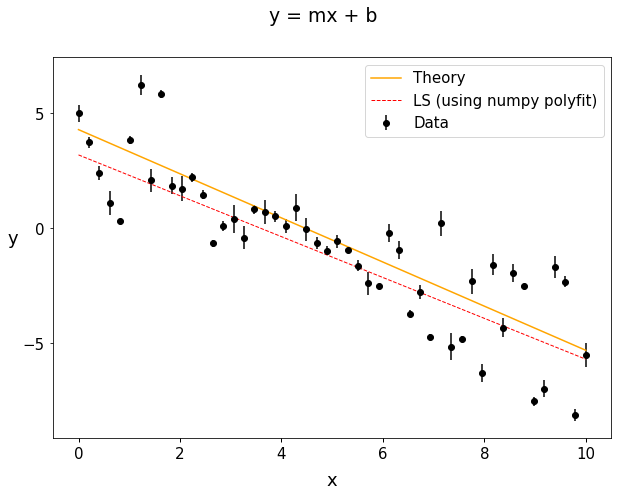

In [94]:
# Fit with numpy polyfit
(param,cov) = np.polyfit(x,y,1,w=1/yerr,cov=True)
print("with numpy.polyfit() we predict:")
# Predict line values with polyfit params:
fitp = np.poly1d(param)
ypolyfit = fitp(x)

print("m = {0:.3f} ± {1:.3f}".format(param[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(param[1], np.sqrt(cov[1, 1])))


# Plot the results
ls = 18 #label fontsize
ts = 15 #tick label fontsize
f = plt.figure(figsize=(10,7))                      # define figure
f.suptitle("y = mx + b",fontsize=ls*1.05)           # set figure title
ax = f.add_subplot(111)                             # add a subplot (just one) to the figure
ax.errorbar(x, y, yerr=yerr,fmt='o',label="Data",c="k")   # plot data & errors
ax.plot(x,y_theory,label="Theory",c="orange")             # plot theoretical line
ax.plot(x, ypolyfit,'r--',lw=1,label="LS (using numpy polyfit)")
ax.set_xlabel("x",fontsize=ls,labelpad=10)          # set axes labels
ax.set_ylabel("y",fontsize=ls,rotation=0,labelpad=10)
ax.set_xticks(np.arange(0,11,2))                    # set axes ticks
ax.set_yticks([-5,0,5])
ax.tick_params(axis="both",which="major",labelsize=ts,direction="out",pad=5,right=False,top=False) # adjust ticks
ax.tick_params(axis="x",rotation=0,color="k",labelcolor="k",width=1,length=4)
ax.legend()                                         # add the legend
plt.show()                                          # display the entire figue

Because we know our uncertainties are incorrect, we'll have to adjust the LS method to account for this and determine the extent to which they're underestimated. We'll refer to an "adjusted" uncertainty which accounts for the fractional underestimation $f$:

$s_i^2 = \sigma^2_i + f^2 (mx_i+b)^2$


We adapt the general Gaussian likelihood:

$\mathcal{L}(y_i|x_i,\sigma_i,\vec{p}) = \prod_i \frac{1}{\sqrt{2\pi \sigma_i}} exp \bigg[-\frac{(y_{obs,i} - y_{fit}(x_i|\vec{p}))^2}{2\sigma_i^2} \bigg]$ 

where $y_{fit}(x_i|\vec{p})$ is the predicted model with parameters $\vec{p}$.  

In our case,  $y_{fit}(x_i|\vec{p}) = y_{fit}(x_i|m,b) = mx_i+b$

Exponentials suck, so let's calculate the log likelihood instead.
The log likelihood for the specific linear model in this case is:

$\ln \mathcal{L}(y|x,\sigma,m,b,f) = -\frac{1}{2}\sum_i\bigg[\frac{(y_{obs,i} - mx_i - b)^2}{s_i^2} + \ln(2\pi s_i^2)\bigg]$

In [95]:
def log_likelihood(params, y, x, yerr):
    m, b, log_f = params
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

LS estimates:
m =  -0.8882055306901517 
b =  3.1943391334513405
*same as LS estimates from np.polyfit(): 
m =  -0.8882055306901514 
b =  3.194339133451338

Maximum likelihood estimates:
m = -0.945
b = 3.690
f = 0.737


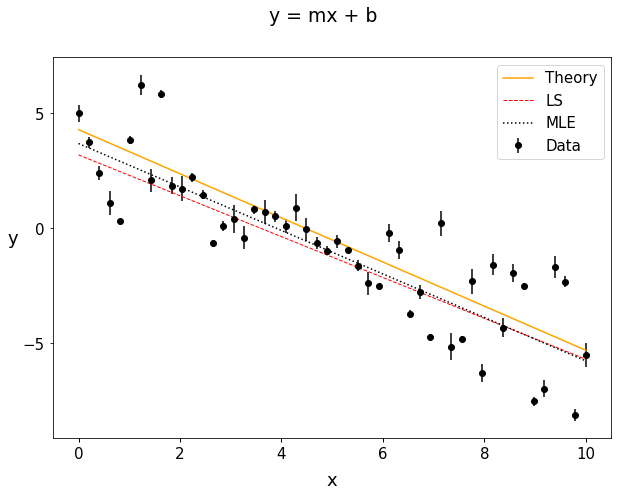

In [96]:
from scipy.optimize import minimize


# Least Squares method from scratch, because that's how the emcee tutorial does it:
A = np.vander(x, 2)      # 
C = np.diag(yerr * yerr) # generalized covariance matrix for our data
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2)) # Invert to find our estimated parameters m,b
print("LS estimates:\nm = ",w[0],"\nb = ",w[1])
print("*same as LS estimates from np.polyfit(): \nm = ",param[0],"\nb = ",param[1])

# Do the MLE
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args) # we'll minimize this negative log likelihood
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3) # initial guesses for parameters ("priors")
soln = minimize(nll, initial, args=(y,x,yerr)) # minimize
m_mle, b_mle, log_f_mle = soln.x

print("\nMaximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))



# Plot the results
ls = 18 #label fontsize
ts = 15 #tick label fontsize
x0 = np.linspace(0, 10, 500)
f = plt.figure(figsize=(10,7))                      # define figure
f.suptitle("y = mx + b",fontsize=ls*1.05)           # set figure title
ax = f.add_subplot(111)                             # add a subplot (just one) to the figure
ax.errorbar(x, y, yerr=yerr,fmt='o',label="Data",c="k")   # plot data & errors
ax.plot(x,y_theory,label="Theory",c="orange")             # plot theoretical line
#ax.plot(x,y_polyfit,'r--',lw=1,label="LS (using numpy polyfit)")
ax.plot(x0, np.dot(np.vander(x0, 2), w),'r--',lw=1,label="LS")
ax.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="MLE")
ax.set_xlabel("x",fontsize=ls,labelpad=10)          # set axes labels
ax.set_ylabel("y",fontsize=ls,rotation=0,labelpad=10)
ax.set_xticks(np.arange(0,11,2))                    # set axes ticks
ax.set_yticks([-5,0,5])
ax.tick_params(axis="both",which="major",labelsize=ts,direction="out",pad=5,right=False,top=False) # adjust ticks
ax.tick_params(axis="x",rotation=0,color="k",labelcolor="k",width=1,length=4)
ax.legend()                                         # add the legend
plt.show()                                          # display the entire figue

How to we incorporate our estimate of $f$ into our uncertainties?  MCMC.  We'll need a (log) probability distribution of our parameters m,b,log(f) to draw samples from.

To get this probability distribution, we'll need Bayes' Theorem.  

$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$

where $P(A|B)$ is the probability of A given B, $P(A|B)$ is probability of B given A, $P(A)$ is the prior distribution, and  $P(B)$ is the evidence (unecessary in this case).

$P(A|B) \propto P(B|A)P(A)$ 

Simplify with logarithms:

$\log{P(A|B)} \propto \log{P(B|A)} + \log{P(A)}$

With our parameters:

$\log{P(m,b,f|x,y,\sigma)} \propto \log{P(y|x,m,b,f,\sigma)} + \log{P(m,b,f)}$

log(probability of m,b,f given our data+errors) $\propto$ log(likelihood function) + log(prior distribution)

In [107]:
# see Bayes' theorem explanation from MCMC Lab

def log_prior(params): 
    m, b, log_f = params
    if (-5.0 < m < 0.5) and (0.0 < b < 10.0) and (-10.0 < log_f < 1.0):
        return 0.0
    return -np.inf

def log_probability(params, x, y, yerr):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, yerr)

In [98]:
# Generate a bunch of intial positions for the walkers, for all three parameters m,b,f
pos = soln.x + 1e-4 * np.random.randn(50, 3) # we'll have 50 walkers
nwalkers, ndim = pos.shape

# sample the distribution and marginalize
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True); # run for 5000 steps

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 259.77it/s]


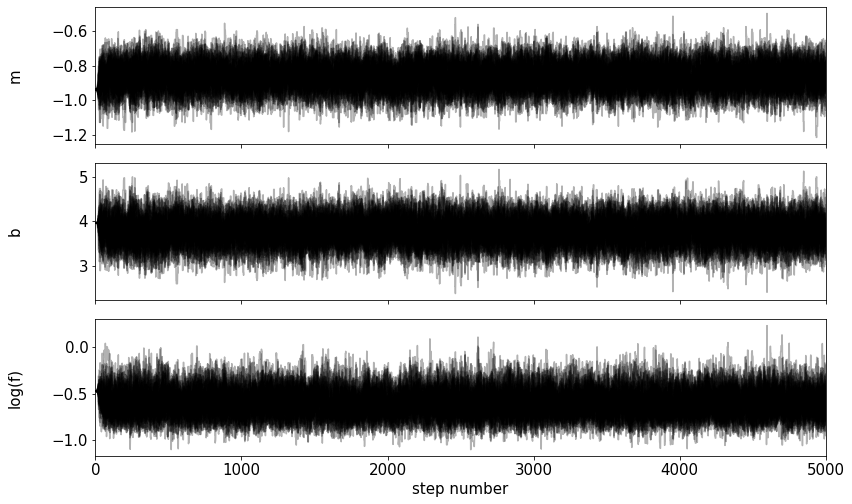

In [99]:
fig, axes = plt.subplots(3, figsize=(12, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

plt.tight_layout()
axes[-1].set_xlabel("step number");

In [120]:
tau = sampler.get_autocorr_time()
print('approximately how many steps it took to"forget" starting point = ',tau)
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

approximately how many steps it took to"forget" starting point =  [39.64086603 38.98131047 35.20906952]


<Figure size 864x864 with 0 Axes>

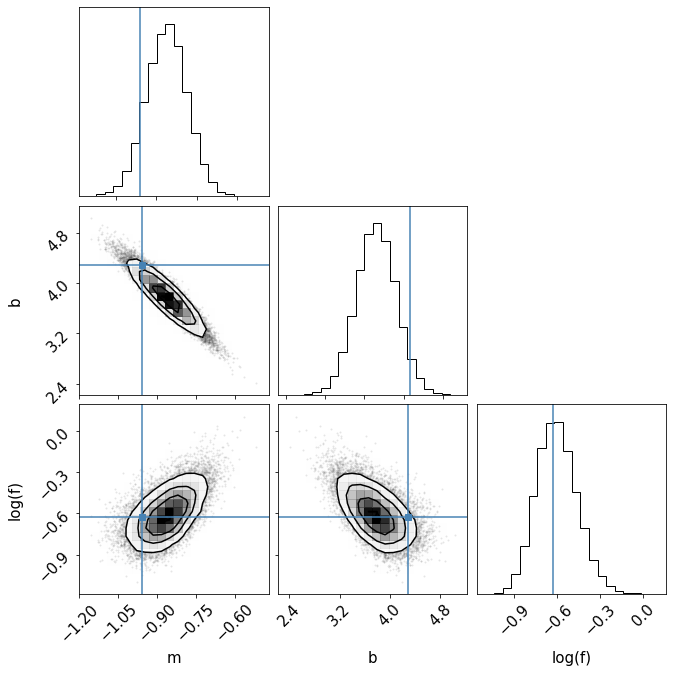

In [116]:
labels = ["m", "b", "log(f)"]
plt.figure(figsize=[12,12])
corner.corner(flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)],
              smooth=0.5,fig=plt.figure(figsize=[10,10]));

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

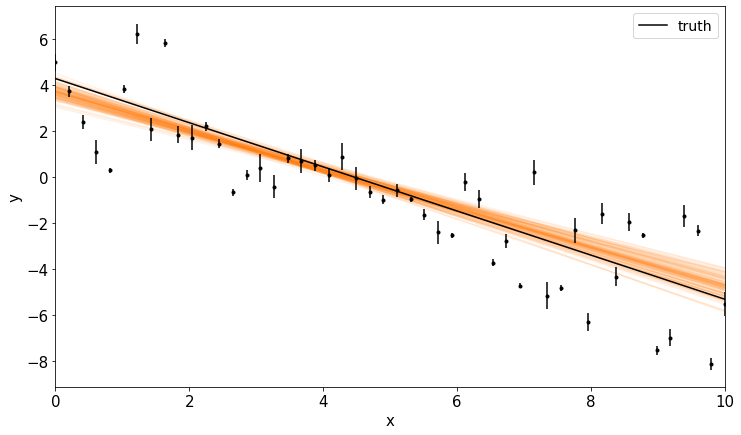

In [119]:
from IPython.display import display, Math

# print the fitted parameters, determine uncertainties based on quantiles of their probability distribution
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
inds = np.random.randint(len(flat_samples), size=100)

# Plot the MCMC results
plt.figure(figsize=[12,7])
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");